# train_dataset, test_datasetを作成

In [1]:
import os
import os.path as osp
import glob
from PIL import Image
import numpy as np
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torchvision
import torchvision.transforms as transforms

In [2]:
CLASSES = ["bird", "cat", "deer", "dog", "frog", "horse"]
class Dataset(data.Dataset):
    def __init__(self, file_paths_list, transform, phase):
        self.file_paths_lsit = file_paths_list
        self.transform = transform
        self.train = True if phase=="train" else False
        
    def __len__(self):
        return len(self.file_paths_lsit)
    
    def __getitem__(self, index):
        # 読み込み
        path = self.file_paths_lsit[index]
        img = Image.open(path) # [高さ][幅][色RGB]
        
        # 前処理
        img_transformed = self.transform(img)
        
        # ラベル
        label = path.split("/")[4]
        label = CLASSES.index(label)
        
        return path, img_transformed, label

In [3]:
# ファイルのpathリスト作成
train_dataset_paths = "./dataset/cifar/train/*/*"
test_dataset_paths = "./dataset/cifar/test/*/*"

train_dataset_paths_list = [_ for _ in glob.glob(train_dataset_paths)]
test_dataset_paths_list = [_ for _ in glob.glob(test_dataset_paths)]

In [4]:
print("len(train_dataset_paths_list):", len(train_dataset_paths_list))
print("len(test_dataset_paths_list):", len(test_dataset_paths_list))

len(train_dataset_paths_list): 30000
len(test_dataset_paths_list): 4000


In [5]:
# 前処理
data_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [6]:
train_dataset = Dataset(train_dataset_paths_list, data_transforms, "train")

In [24]:
batch_size = 32
train_loader = data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [7]:
print("len(train_dataset):", len(train_dataset))

len(train_dataset): 30000


In [8]:
index = 12012
print("path :", train_dataset[index][0])
print("shape:", train_dataset[index][1].shape)
print("label:", train_dataset[index][2])

path : ./dataset/cifar/train/cat/35931_cat.png
shape: torch.Size([3, 32, 32])
label: 1


# ペアを返すデータセットの作成

In [9]:
train_labels = np.array([train_dataset[index][2] for index in range(len(train_dataset))])

In [10]:
train_labels

array([0, 0, 0, ..., 2, 2, 2])

In [11]:
class SiameseCIFAR(data.Dataset):
    def __init__(self, dataset, dataset_labels):
        self.train = dataset.train # flag
        self.dataset = dataset # dataset instance
        self.dataset_labels = dataset_labels # labels list
        if self.train:
            self.train_labels = self.dataset_labels
            self.labels_set = set(self.dataset_labels)
            self.labels_to_indices = {label : np.where(self.dataset_labels == label)[0] for label in self.labels_set} # key: label , value: labelのindeices
        else:
            pass
        
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, index):
        if self.train:
            target = np.random.randint(0, 2) # 0 or 1, 
            path1, img1, label1 = self.dataset[index]
            if target == 1: # 同じラベルの違うデータを選択
                siamese_index = index
                while siamese_index == index:
                    siamese_index = np.random.choice(self.labels_to_indices[label1])
            else:
                siamese_label = np.random.choice(list(self.labels_set - set([label1])))
                siamese_index = np.random.choice(self.labels_to_indices[siamese_label])
            path2, img2, label2 = self.dataset[siamese_index]
        else:
            pass
        
        pair_paths = (path1, path2)
        pair_imgs = (img1, img2)
        pair_labels = (label1, label2)
        
        
        return (pair_paths, pair_imgs, pair_labels, target)

In [12]:
siamese_train_dataset = SiameseCIFAR(train_dataset, train_labels)

In [13]:
print("paths:", siamese_train_dataset[0][0])
print("shapes: ", siamese_train_dataset[0][1][0].shape, siamese_train_dataset[0][1][1].shape)
print("labels: ", siamese_train_dataset[0][2])

paths: ('./dataset/cifar/train/bird/9002_bird.png', './dataset/cifar/train/bird/30874_bird.png')
shapes:  torch.Size([3, 32, 32]) torch.Size([3, 32, 32])
labels:  (0, 3)


In [14]:
batch_size = 32
siamese_train_loader = data.DataLoader(siamese_train_dataset, batch_size=batch_size, shuffle=True)

In [15]:
for batch_idx, a in enumerate(siamese_train_loader):
    print("paths:", a[0])
    print("shapes:", a[1])
    print("labels:", a[2])
    print("targets:", a[3])
    break

paths: [('./dataset/cifar/train/cat/15642_cat.png', './dataset/cifar/train/bird/8438_bird.png', './dataset/cifar/train/frog/33733_frog.png', './dataset/cifar/train/horse/38367_horse.png', './dataset/cifar/train/dog/29832_dog.png', './dataset/cifar/train/frog/40498_frog.png', './dataset/cifar/train/frog/41549_frog.png', './dataset/cifar/train/frog/6521_frog.png', './dataset/cifar/train/bird/9917_bird.png', './dataset/cifar/train/bird/28618_bird.png', './dataset/cifar/train/cat/37408_cat.png', './dataset/cifar/train/horse/10028_horse.png', './dataset/cifar/train/frog/45543_frog.png', './dataset/cifar/train/bird/38186_bird.png', './dataset/cifar/train/frog/2100_frog.png', './dataset/cifar/train/frog/14457_frog.png', './dataset/cifar/train/dog/46096_dog.png', './dataset/cifar/train/deer/23231_deer.png', './dataset/cifar/train/cat/22216_cat.png', './dataset/cifar/train/frog/18682_frog.png', './dataset/cifar/train/horse/25497_horse.png', './dataset/cifar/train/dog/46482_dog.png', './dataset/

# EmbeddingNetの設定

In [16]:
class EmbeddingNet(nn.Module):
    """ Basic Embedding Network
    """
    def __init__(self, fc_input_size=64*6*6):
        super(EmbeddingNet, self).__init__()
        self.convnet = nn.Sequential(nn.Conv2d(3, 32, kernel_size=5, stride=1, padding=0),
                                    nn.ReLU(),
                                    nn.MaxPool2d(kernel_size=2, stride=2),
                                    nn.Conv2d(32, 64, 3),
                                    nn.ReLU(),
                                    nn.MaxPool2d(kernel_size=2, stride=2),
                                    )
        self.fc = nn.Sequential(nn.Linear(fc_input_size, 256),
                                nn.ReLU(),
                                nn.Linear(256, 64),
                                nn.Linear(64, 2),
                                )
    
    def forward(self, x):
        """ convnet -> flatten -> fc 
            input: torch.Size([batch_size, 3, 64, 64])
            output: torch.Size([batch_size, 64])
        """
        x = self.convnet(x)
        batch_size = x.size(0)
        x = x.view(batch_size, -1) # flatten
        x = self.fc(x)
        return x


class EmbeddingNetL2(EmbeddingNet):
    """ output l2 norm
    """
    def __init__(self):
        super(EmbeddingNetL2, self).__init__()

    def forward(slef, x):
        x = super(EmbeddingNetL2, self).forward(x)
        x /= x.pow(2).sum(1, keepdim=True).sqrt()
        return x

In [17]:
class SiameseNet(nn.Module):
    def __init__(self, embedding_net):
        super(SiameseNet, self).__init__()
        self.embedding_net = embedding_net
    
    def forward(self, x1, x2):
        output1 = self.embedding_net(x1)
        output2 = self.embedding_net(x2)
        return output1, output2
    
    def get_embedding(self, x):
        return self.embedding_net(x)

In [18]:
class ContrastiveLoss(nn.Module):
    def __init__(self, margin):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin
        self.eps = 1e-9
        
    def forward(self, output1, output2, target, size_average=True):
        distances = (output2 - output1).pow(2).sum(1)
        losses = 0.5 * (target.float() * distances + (1 + -1 * target).float() * F.relu(self.margin - (distances + self.eps).sqrt()).pow(2))
        return losses.mean() if size_average else losses.sum()

In [19]:
margin = 1
embedding_net = EmbeddingNet()
model = SiameseNet(embedding_net)
loss_fn = ContrastiveLoss(margin)
lr = 1e-3
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = optim.lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)
n_epochs=20
log_interval=100

In [20]:
# fit(siamese_train_loader, model, loss_fn, optimizer, scheduler, n_epochs, cuda, )

In [21]:
# fit 関数をそのまま書く
start_epoch = 0
losses = []
total_loss = 0

# train
for epoch in range(start_epoch, n_epochs):
    scheduler.step()
    model.train()
    losses = []
    total_loss = 0
    for batch_idx, (paths, datas, labels, targets) in enumerate(siamese_train_loader):
        x1, x2 = datas
        optimizer.zero_grad()
        outputs = model(x1, x2) # data = ([(x11, x12), (x21, x22), ....])
        output1, output2 = outputs
        loss = loss_fn(output1, output2, targets)
        losses.append(loss.item())
        total_loss += loss.item()
        loss.backward()
        optimizer.step()
        if batch_idx % 10 == 0:
            print("losss: ", loss.item())

losss:  0.2641046345233917
losss:  0.21856871247291565
losss:  0.17847199738025665
losss:  0.14020411670207977
losss:  0.16290926933288574
losss:  0.1429530829191208
losss:  0.17694967985153198
losss:  0.13999208807945251
losss:  0.1450454145669937
losss:  0.12447061389684677
losss:  0.10931292921304703
losss:  0.17176605761051178
losss:  0.19038262963294983
losss:  0.11320926249027252
losss:  0.1668688803911209
losss:  0.16151626408100128
losss:  0.1585909128189087
losss:  0.16282394528388977
losss:  0.15064573287963867
losss:  0.12481474131345749
losss:  0.17007187008857727
losss:  0.1371239274740219
losss:  0.15493373572826385
losss:  0.11669903248548508
losss:  0.1509656459093094
losss:  0.13888885080814362
losss:  0.14122268557548523
losss:  0.18178631365299225
losss:  0.1712854504585266
losss:  0.14378921687602997
losss:  0.17044365406036377
losss:  0.15908384323120117
losss:  0.13406020402908325
losss:  0.12056534737348557
losss:  0.1523151695728302
losss:  0.1528920978307724
lo

KeyboardInterrupt: 

# Plot Embeddings

In [34]:
import matplotlib.pyplot as plt
%matplotlib inline
CLASSES = ["bird", "cat", "deer", "dog", "frog", "horse"]
classes_num = [i for i in range(len(CLASSES))]
colors = ["red", "blue", "pink", "orange", "yellow", "green"]
def plot_embeddings(embeddings, targets, xlim=None, ylim=None):
    plt.figure(figsize=(10,10))
    for i in range(len(CLASSES)):
        inds = np.where(targets==i)[0]
        plt.scatter(embeddings[inds,0], embeddings[inds,1], alpha=0.5, color=colors[i])
    if xlim:
        plt.xlim(xlim[0], xlim[1])
    if ylim:
        plt.xlim(ylim[0], ylim[1])
    plt.legend(CLASSES)

def extract_embeddings(dataloader, model):
    with torch.no_grad():
        model.eval()
        embeddings = np.zeros((len(dataloader.dataset), 2))
        labels = np.zeros(len(dataloader.dataset))
        k = 0
        for paths, images, targets in dataloader:
            embeddings[k:k+len(images)] = model.get_embedding(images).data.cpu().numpy()
            labels[k:k+len(images)] = targets.numpy()
            k += len(images)
    return embeddings, labels

In [32]:
train_embeddings, train_labels = extract_embeddings(train_loader, model)

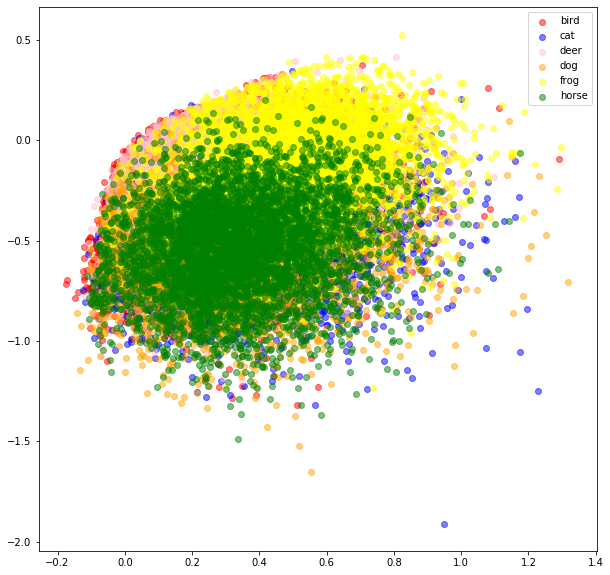

In [35]:
plot_embeddings(train_embeddings, train_labels)